In [15]:
import sys
sys.path.append('../')

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import warnings
from scipy.optimize import minimize
from torch.utils.data import DataLoader

from src.model import SindyModel
from baseline.model import LSTMModel, MLP
from src.main import get_args
from src.dataloader import ScrewdrivingDataset

In [17]:
%matplotlib inline
plt.ioff()

In [18]:
ARGS = get_args()

model_dir = os.path.join('..', 'out', 'sindy-model-out', 'checkpoints')
processed_model_dir = os.path.join('..', 'out', 'sindy-out-processed')
singal_data_dir = os.path.join('..', 'out', 'sindy-data')
out_dir = os.path.join('..', 'out', 'final-plots')

os.makedirs(out_dir, exist_ok=True)

In [19]:
test_loader = DataLoader(ScrewdrivingDataset(mode='test', **{**vars(ARGS), 'data_dir': singal_data_dir}))
test_x = torch.cat([batch[0] for batch in test_loader], dim=0)

test_y = [batch[1].numpy() for batch in DataLoader(ScrewdrivingDataset(mode='test', **{**vars(ARGS), 'data_dir': singal_data_dir}))]
test_y = np.concatenate(test_y, axis=0)
test_y = test_y.reshape(test_y.shape[0], test_y.shape[-1])

In [20]:
def signal_error(params, reference_signals, target_signals):
    adjusted_signals = adjust_signal(target_signals, *params)
    return np.sum((reference_signals[0] - adjusted_signals[0]) ** 2) + np.sum((reference_signals[1] - adjusted_signals[1]) ** 2)

def adjust_signal(target_signals, mean_adjustment, time_shift):
    return [
        adjust_signal_single(target_signals[0], mean_adjustment, time_shift),
        adjust_signal_single(target_signals[1], mean_adjustment, time_shift),
    ]
    
def adjust_signal_single(target_signal, mean_adjustment, time_shift):
    shifted_target_signal = np.interp(np.arange(len(target_signal)), np.arange(len(target_signal)) - time_shift, target_signal)
    return shifted_target_signal + mean_adjustment

In [21]:
def plot_signals(pred_signals_vel, ref_signals_vel, pred_signals_dist, ref_signals_dist, model_name, show=False):
    t = np.arange(pred_signals_vel[0].shape[0]) / 30
    band_width = 1 / 1000
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    
    axs[0].plot(t, ref_signals_vel[0], label='Measured Vx', color='orange')
    axs[1].plot(t, ref_signals_vel[1], label='Measured Vy', color='orange')
    axs[0].plot(t, pred_signals_vel[0], label='Predicted Vx', dashes=[6, 2])
    axs[1].plot(t, pred_signals_vel[1], label='Predicted Vy', dashes=[6, 2])
    
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Velocity Vx (m/s)')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Velocity Vy (m/s)')
    
    axs[0].legend()
    axs[0].grid(True)
    axs[1].legend()
    axs[1].grid(True)
    
    fig.suptitle('Velocity Prediction')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f'velocity_{model_name}.png'))
    if show:
        plt.show()
    plt.close()

    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
       
    axs[0].fill_between(t, ref_signals_dist[0] - band_width, ref_signals_dist[0] + band_width, color='green', alpha=0.3)
    axs[0].plot(t, ref_signals_dist[0], label='Measured x', color='orange')
    
    axs[1].fill_between(t, ref_signals_dist[1] - band_width, ref_signals_dist[1] + band_width, color='green', alpha=0.3)
    axs[1].plot(t, ref_signals_dist[1], label='Measured y', color='orange')
    
    axs[0].plot(t, pred_signals_dist[0], label='Inferred x', dashes=[6, 2])
    axs[1].plot(t, pred_signals_dist[1], label='Inferred y', dashes=[6, 2])
    
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Distance x (m)')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Distance y (m)')
    
    axs[0].legend()
    axs[0].grid(True)
    axs[1].legend()
    axs[1].grid(True)
    
    fig.suptitle('Distance Inference')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f'distance_{model_name}.png'))
    if show:
        plt.show()
    plt.close()

    # fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    #
    # axs.plot(ref_signals_dist[0], ref_signals_dist[1], label='Measured Path Trace', color='orange')
    # axs.plot(pred_signals_dist[0], pred_signals_dist[1], label='Predicted Path Trace', dashes=[6, 2])
    #
    # axs.set_xlabel('Distance x (m)')
    # axs.set_ylabel('Distance y (m)')
    #
    # axs.legend()
    # axs.grid(True)
    #
    # fig.suptitle('Path Traced')
    # plt.tight_layout()
    # plt.savefig(os.path.join(out_dir, f'trace_{model_name}.png'))
    # if show:
    #     plt.show()
    # plt.close()

In [22]:
def gen_pos_from_vel(start_pos, vel_x, vel_y):
    positions = [start_pos]
    x, y = start_pos
    time_period = 1 / 3  # seconds
    
    for t in range(segment_length - 1):
        x += np.real(vel_x[t]) * time_period
        y += np.real(vel_y[t]) * time_period
        positions.append((x, y))

    positions = np.array(positions)
    
    return [positions[:, 0], positions[:, 1]]

In [23]:
model_params_df = pd.read_csv(os.path.join(processed_model_dir, 'cumulative_results.csv'))
segment_params_df = pd.read_csv(os.path.join(processed_model_dir, 'segmented', 'best_segmented_results.csv'))
model_results = []

model_names = model_params_df['model_name']
# model_names = ['model_2024-05-11 15:00:41.789464.pth']
weight_adjustment = 0.15

for idx, model_name in enumerate(model_names):
    model_row = model_params_df[model_params_df.model_name == model_name].iloc[0]
    if not model_name in segment_params_df['model_name'].values:
        continue
    segment_row = segment_params_df[segment_params_df.model_name == model_name].iloc[0]
    
    segment_params = (segment_row.mean_adjustment, segment_row.time_shift)
    full_x_params = (model_row.mean_adjustment_vx, model_row.time_shift_vx)
    full_y_params = (model_row.mean_adjustment_vy, model_row.time_shift_vy)
    ref_segment_start = segment_row.start_ref
    target_segment_start = segment_row.start_target
    segment_length = segment_row.segment_length
    
    
    with (torch.no_grad()):
        model = SindyModel(**vars(ARGS))
        model.load_state_dict(torch.load(os.path.join(model_dir, model_name)))
        model.eval()
        
        pred_y = model(test_x).numpy()
        pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[-1]).astype(np.complex64)
        
        reference_signal_x = np.copy(test_y)[:, 0]
        target_signal_x = pred_y[:, 0]
        adjusted_vx = adjust_signal_single(target_signal_x, *full_x_params)

        reference_signal_y = np.copy(test_y)[:, 1]
        target_signal_y = pred_y[:, 1]
        adjusted_vy = adjust_signal_single(target_signal_y, *full_y_params)

        best_segmented_vx, best_segmented_vy = adjust_signal([adjusted_vx, adjusted_vy], *segment_params)

        start_pos = test_x.numpy()[ref_segment_start, 0, :2].tolist()
        # true_pos = test_x.numpy()[ref_segment_start:ref_segment_start + segment_length, 0, :2]
        true_pos = gen_pos_from_vel(
            start_pos,
            reference_signal_x[ref_segment_start:ref_segment_start + segment_length],
            reference_signal_y[ref_segment_start:ref_segment_start + segment_length]
        )
        
        gen_pos = gen_pos_from_vel(
            start_pos,
            best_segmented_vx[target_segment_start:target_segment_start + segment_length] * weight_adjustment + \
                reference_signal_x[ref_segment_start:ref_segment_start + segment_length] * (1 - weight_adjustment),
            best_segmented_vy[target_segment_start:target_segment_start + segment_length] * weight_adjustment + \
                reference_signal_y[ref_segment_start:ref_segment_start + segment_length]  * (1 - weight_adjustment)
        )

        errors = np.sqrt((true_pos[0] - gen_pos[0]) ** 2 + (true_pos[1] - gen_pos[1]) ** 2)
        mean_error = np.mean(errors)
        max_error = np.max(errors)
        std_error = np.std(errors)

        print(f'#: {idx}, model_name: {model_name}, mean_error: {mean_error:.4f}, max_error: {max_error:.4f}, error_std_dev: {std_error:.4f}')

        model_results.append({
            'model_name': model_name,
            'mean_error': mean_error,
            'max_error': max_error,
            'std_error': std_error,
        })

#: 618, model_name: model_2025-02-08 22:57:59.042278_epoch-21.pth, mean_error: 0.0105, max_error: 0.0224, error_std_dev: 0.0070
#: 620, model_name: model_2025-02-08 22:58:06.210843_epoch-23.pth, mean_error: 0.0101, max_error: 0.0214, error_std_dev: 0.0066
#: 622, model_name: model_2025-02-08 22:58:13.384064_epoch-25.pth, mean_error: 0.0107, max_error: 0.0227, error_std_dev: 0.0071
#: 623, model_name: model_2025-02-08 22:58:19.568080_epoch-26.pth, mean_error: 0.0109, max_error: 0.0232, error_std_dev: 0.0072
#: 632, model_name: model_2025-02-08 22:58:54.354291_epoch-35.pth, mean_error: 0.0123, max_error: 0.0259, error_std_dev: 0.0078
#: 633, model_name: model_2025-02-08 22:58:57.943967_epoch-36.pth, mean_error: 0.0133, max_error: 0.0283, error_std_dev: 0.0083
#: 634, model_name: model_2025-02-08 22:59:01.518567_epoch-37.pth, mean_error: 0.0131, max_error: 0.0278, error_std_dev: 0.0084
#: 635, model_name: model_2025-02-08 22:59:05.095638_epoch-38.pth, mean_error: 0.0141, max_error: 0.0300

In [24]:
results_df = pd.DataFrame(model_results)
results_df

,model_name,mean_error,max_error,std_error
0,model_2025-02-08 22:57:59.042278_epoch-21.pth,0.010533,0.022355,0.006999
1,model_2025-02-08 22:58:06.210843_epoch-23.pth,0.010074,0.021379,0.006638
2,model_2025-02-08 22:58:13.384064_epoch-25.pth,0.010741,0.022684,0.007058
3,model_2025-02-08 22:58:19.568080_epoch-26.pth,0.010856,0.023193,0.007230
4,model_2025-02-08 22:58:54.354291_epoch-35.pth,0.012323,0.025922,0.007802
...,...,...,...,...
117,model_2025-02-09 10:53:25.724965_epoch-39.pth,0.021781,0.036945,0.011282
118,model_2025-02-09 10:53:32.891830_epoch-41.pth,0.011703,0.022796,0.006439
119,model_2025-02-09 10:53:36.486705_epoch-42.pth,0.011715,0.023131,0.006478
120,model_2025-02-09 11:03:28.282413_epoch-45.pth,0.028666,0.057914,0.016791


In [25]:
m5_model, m4_model, m6_model = results_df.sort_values('mean_error')['model_name'].head(3).tolist()

In [26]:
def print_dominant_sindy_terms(model, top_n=3):
    # Get coefficients and convert them to a numpy array
    coefficients = model.coefficients.detach().cpu().numpy()

    # Generate feature names from PolynomialFeatures
    feature_names = model._Theta.get_feature_names_out(
        input_features=[f"x{i}" for i in range(model._params.input_var_dim)]
    )

    # If sine terms are used, append them to the feature names
    if model._params.use_sine:
        sine_terms = [f"sin(x{i})" for i in range(model._params.input_var_dim)]
        feature_names = list(feature_names) + sine_terms

    # Loop through each state variable
    for state_idx in range(coefficients.shape[1]):
        print(f"\nState Variable {state_idx + 1}:")

        # Get coefficients for this state variable
        coeffs = coefficients[:, state_idx]

        # Find indices of top N largest coefficients (by absolute value)
        top_indices = np.argsort(np.abs(coeffs))[:][::-1]

        # Print dominant terms and their coefficients
        for idx in top_indices:
            term = feature_names[idx]
            coeff_value = coeffs[idx]
            print(f"  Term: {term}, Coefficient: {coeff_value:.4f}")


screw_m4, model_name: model_2025-02-09 10:20:50.023251_epoch-33.pth, mean_error: 0.0004, max_error: 0.0009, error_std_dev: 0.0002

State Variable 1:
  Term: x2^2 x12, Coefficient: -0.1153
  Term: x3^3, Coefficient: -0.1103
  Term: x1 x2^2, Coefficient: -0.1082
  Term: x1 x2 x15, Coefficient: 0.1002
  Term: x2 x11 x16, Coefficient: 0.0980
  Term: x2 x3 x14, Coefficient: -0.0961
  Term: x3 x10 x11, Coefficient: 0.0938
  Term: x0 x2 x12, Coefficient: 0.0936
  Term: x3 x9 x10, Coefficient: 0.0934
  Term: x3 x6 x10, Coefficient: 0.0933
  Term: x3 x16^2, Coefficient: 0.0927
  Term: x3 x11 x13, Coefficient: 0.0925
  Term: x3 x6 x12, Coefficient: 0.0917
  Term: x0 x3 x10, Coefficient: 0.0912
  Term: x2^2 x14, Coefficient: -0.0901
  Term: x3 x5 x12, Coefficient: 0.0898
  Term: x1 x2 x11, Coefficient: 0.0897
  Term: x0 x3 x13, Coefficient: 0.0890
  Term: x2^2 x3, Coefficient: 0.0882
  Term: x3 x4 x11, Coefficient: 0.0879
  Term: x2 x15 x16, Coefficient: 0.0875
  Term: x2 x11 x14, Coefficient: 0.

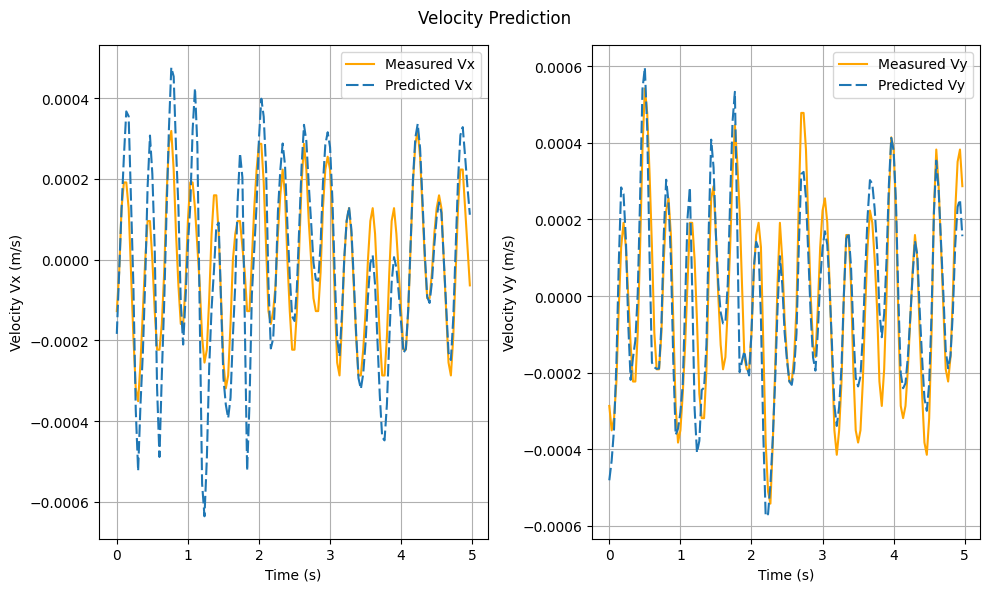

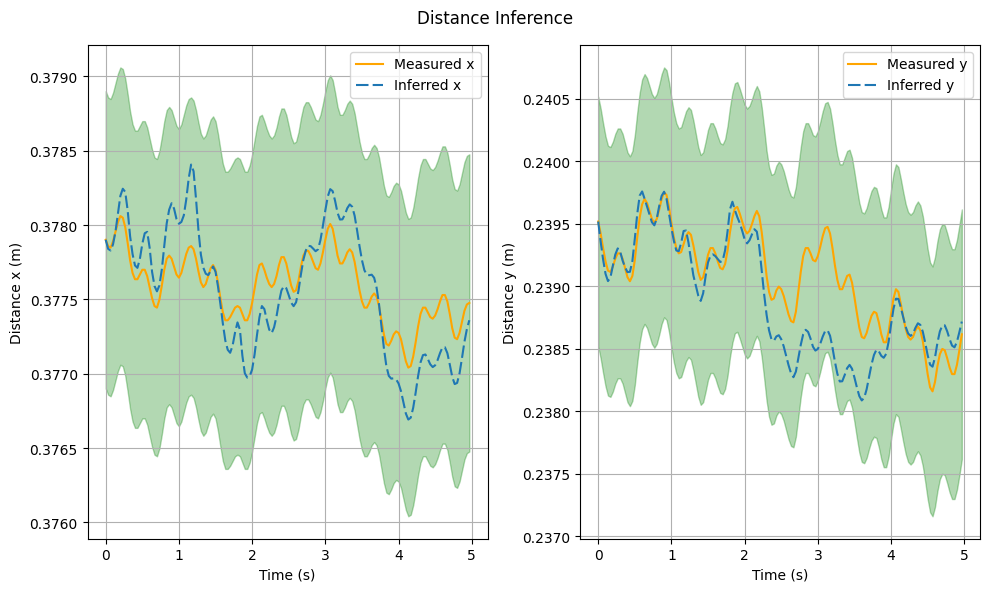

screw_m5, model_name: model_2025-02-09 10:20:42.913767_epoch-31.pth, mean_error: 0.0003, max_error: 0.0008, error_std_dev: 0.0002

State Variable 1:
  Term: x2^2 x12, Coefficient: -0.1119
  Term: x3^3, Coefficient: -0.1075
  Term: x1 x2^2, Coefficient: -0.1047
  Term: x1 x2 x15, Coefficient: 0.0978
  Term: x2 x11 x16, Coefficient: 0.0957
  Term: x3 x9 x10, Coefficient: 0.0929
  Term: x3 x6 x10, Coefficient: 0.0928
  Term: x3 x10 x11, Coefficient: 0.0922
  Term: x2 x3 x14, Coefficient: -0.0918
  Term: x0 x2 x12, Coefficient: 0.0915
  Term: x3 x6 x12, Coefficient: 0.0900
  Term: x0 x3 x10, Coefficient: 0.0895
  Term: x3 x16^2, Coefficient: 0.0894
  Term: x3 x11 x13, Coefficient: 0.0892
  Term: x3 x5 x12, Coefficient: 0.0882
  Term: x1 x2 x11, Coefficient: 0.0872
  Term: x2^2 x14, Coefficient: -0.0868
  Term: x2^2 x7, Coefficient: -0.0859
  Term: x0 x3 x13, Coefficient: 0.0858
  Term: x3 x5 x7, Coefficient: 0.0856
  Term: x2 x15 x16, Coefficient: 0.0853
  Term: x2 x11 x14, Coefficient: 0.

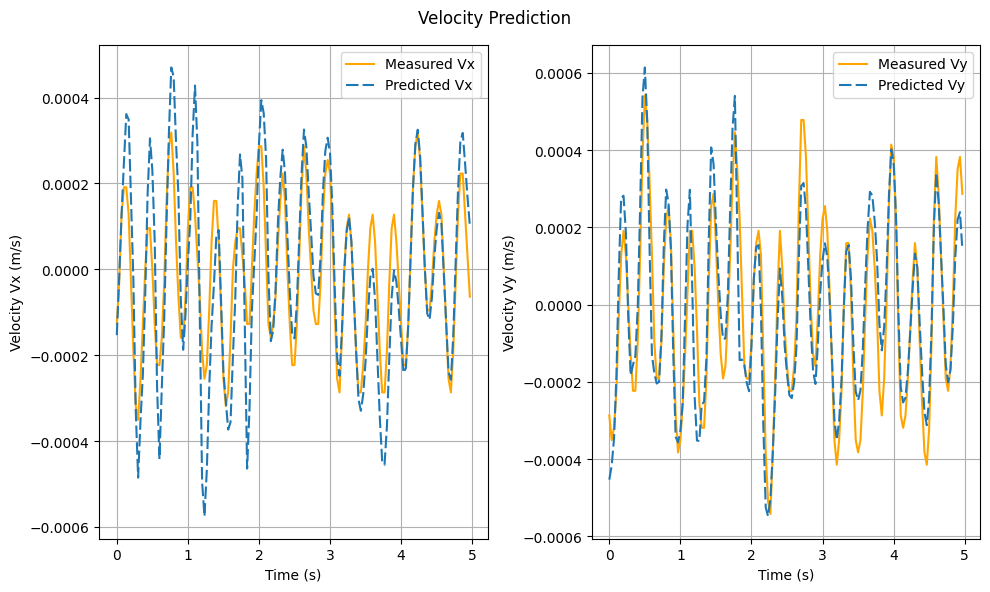

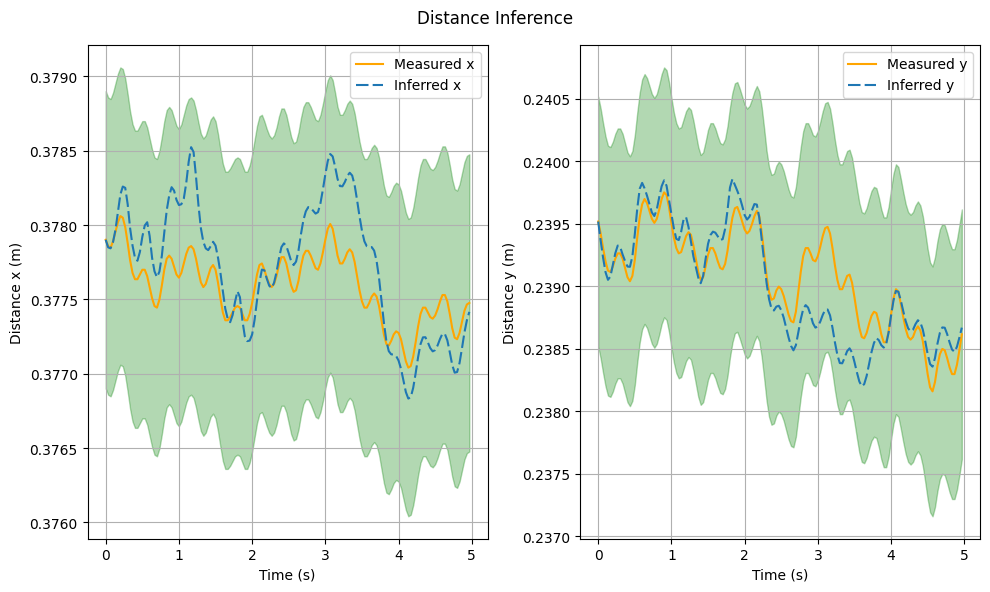

screw_m6, model_name: model_2025-02-09 10:20:57.266285_epoch-35.pth, mean_error: 0.0004, max_error: 0.0010, error_std_dev: 0.0003

State Variable 1:
  Term: x2^2 x12, Coefficient: -0.1191
  Term: x3^3, Coefficient: -0.1129
  Term: x1 x2^2, Coefficient: -0.1121
  Term: x1 x2 x15, Coefficient: 0.1024
  Term: x2 x3 x14, Coefficient: -0.1009
  Term: x2 x11 x16, Coefficient: 0.1000
  Term: x3 x16^2, Coefficient: 0.0964
  Term: x3 x11 x13, Coefficient: 0.0962
  Term: x3 x10 x11, Coefficient: 0.0957
  Term: x0 x2 x12, Coefficient: 0.0954
  Term: x3 x9 x10, Coefficient: 0.0940
  Term: x2^2 x14, Coefficient: -0.0939
  Term: x3 x6 x10, Coefficient: 0.0939
  Term: x3 x6 x12, Coefficient: 0.0935
  Term: x0 x3 x10, Coefficient: 0.0931
  Term: x2^2 x3, Coefficient: 0.0928
  Term: x0 x3 x13, Coefficient: 0.0928
  Term: x1 x2 x11, Coefficient: 0.0918
  Term: x3 x5 x12, Coefficient: 0.0917
  Term: x3 x4 x11, Coefficient: 0.0917
  Term: x2 x15 x16, Coefficient: 0.0895
  Term: x2 x11 x14, Coefficient: 0.

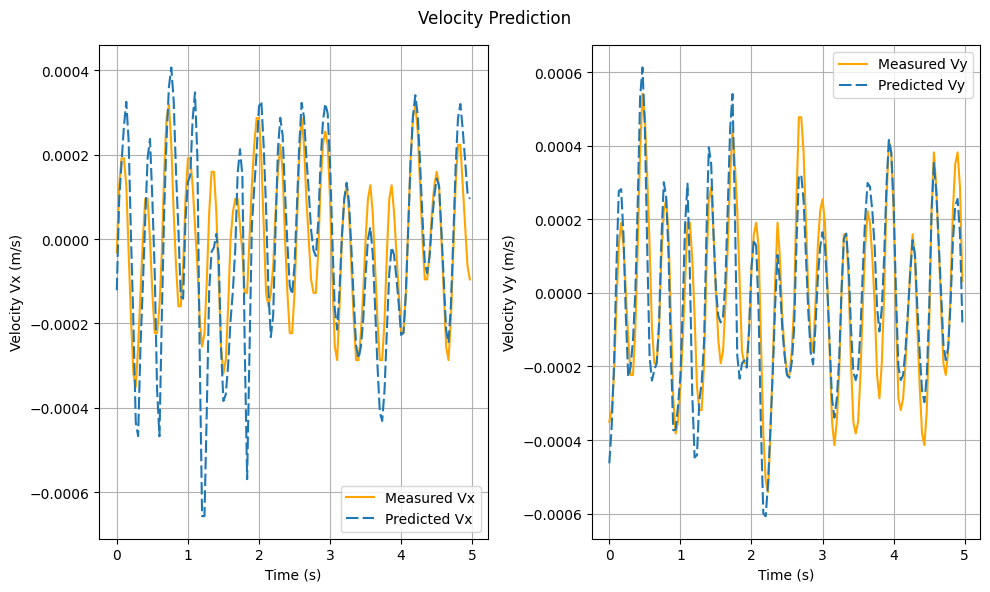

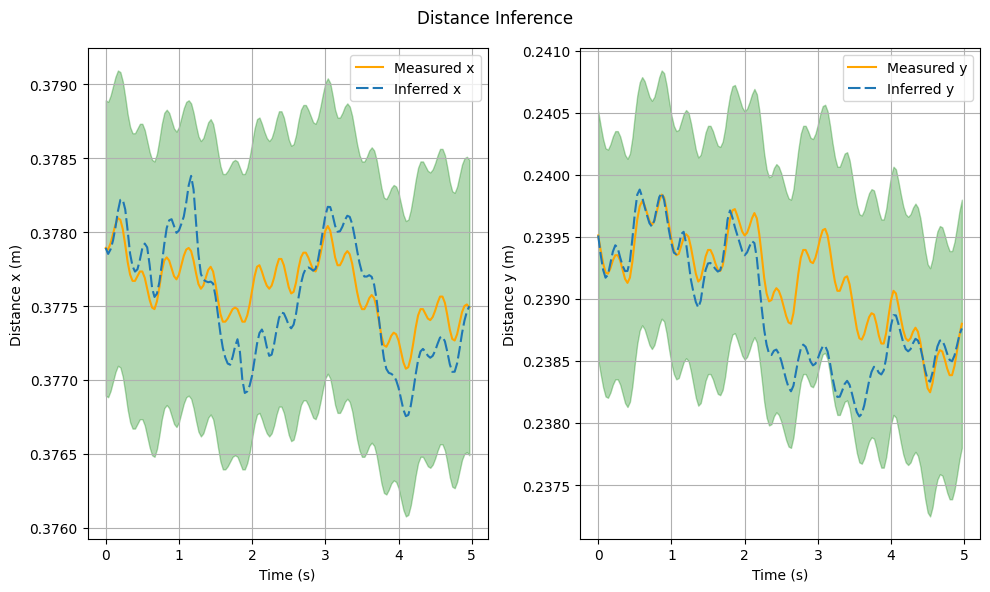

In [27]:
for idx, model_name in enumerate([m4_model, m5_model, m6_model]):
    model_row = model_params_df[model_params_df.model_name == model_name].iloc[0]
    if not model_name in segment_params_df['model_name'].values:
        continue
    segment_row = segment_params_df[segment_params_df.model_name == model_name].iloc[0]

    segment_params = (segment_row.mean_adjustment, segment_row.time_shift)
    full_x_params = (model_row.mean_adjustment_vx, model_row.time_shift_vx)
    full_y_params = (model_row.mean_adjustment_vy, model_row.time_shift_vy)
    ref_segment_start = segment_row.start_ref
    target_segment_start = segment_row.start_target
    segment_length = segment_row.segment_length

    with (torch.no_grad()):
        model = SindyModel(**vars(ARGS))
        model.load_state_dict(torch.load(os.path.join(model_dir, model_name)))
        model.eval()

        pred_y = model(test_x).numpy()
        pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[-1]).astype(np.complex64)

        reference_signal_x = np.copy(test_y)[:, 0]
        target_signal_x = pred_y[:, 0]
        adjusted_vx = adjust_signal_single(target_signal_x, *full_x_params)

        reference_signal_y = np.copy(test_y)[:, 1]
        target_signal_y = pred_y[:, 1]
        adjusted_vy = adjust_signal_single(target_signal_y, *full_y_params)

        best_segmented_vx, best_segmented_vy = adjust_signal([adjusted_vx, adjusted_vy], *segment_params)

        start_pos = test_x.numpy()[ref_segment_start, 0, :2].tolist()
        # true_pos = test_x.numpy()[ref_segment_start:ref_segment_start + segment_length, 0, :2]
        true_pos = gen_pos_from_vel(
            start_pos,
            reference_signal_x[ref_segment_start:ref_segment_start + segment_length],
            reference_signal_y[ref_segment_start:ref_segment_start + segment_length]
        )

        gen_pos = gen_pos_from_vel(
            start_pos,
            best_segmented_vx[target_segment_start:target_segment_start + segment_length] * weight_adjustment + \
            reference_signal_x[ref_segment_start:ref_segment_start + segment_length] * (1 - weight_adjustment),
            best_segmented_vy[target_segment_start:target_segment_start + segment_length] * weight_adjustment + \
            reference_signal_y[ref_segment_start:ref_segment_start + segment_length] * (1 - weight_adjustment)
        )

        errors = np.sqrt((true_pos[0] - gen_pos[0]) ** 2 + (true_pos[1] - gen_pos[1]) ** 2)
        mean_error = np.mean(errors)
        max_error = np.max(errors)
        std_error = np.std(errors)

        print(f'screw_m{idx + 4}, model_name: {model_name}, mean_error: {mean_error:.4f}, max_error: {max_error:.4f}, error_std_dev: {std_error:.4f}')

        print_dominant_sindy_terms(model, top_n=5)

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)

            plot_signals(
                [
                    best_segmented_vx[target_segment_start:target_segment_start + segment_length] * weight_adjustment + \
                    reference_signal_x[ref_segment_start:ref_segment_start + segment_length] * (1 - weight_adjustment),
                    best_segmented_vy[target_segment_start:target_segment_start + segment_length] * weight_adjustment + \
                    reference_signal_y[ref_segment_start:ref_segment_start + segment_length] * (1 - weight_adjustment)
                ],
                [
                    reference_signal_x[ref_segment_start:ref_segment_start + segment_length],
                    reference_signal_y[ref_segment_start:ref_segment_start + segment_length]
                ],
                gen_pos,
                true_pos,
                model_name,
                show=True
            )


../out/baseline/lstm_model.pth
Model: lstm_model, Mean Error: 0.0653, Max Error: 0.1305, Error Std Dev: 0.0379


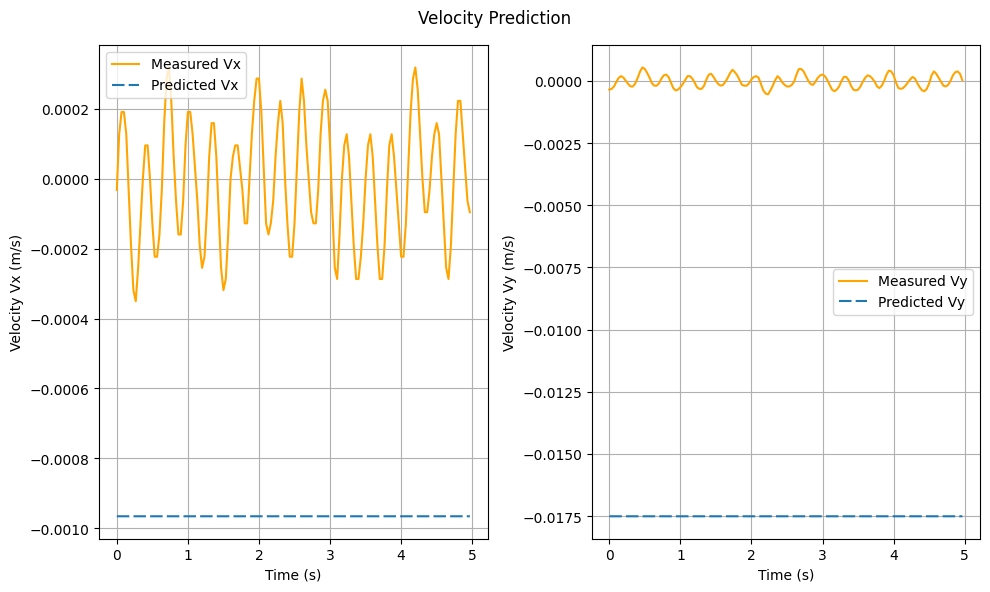

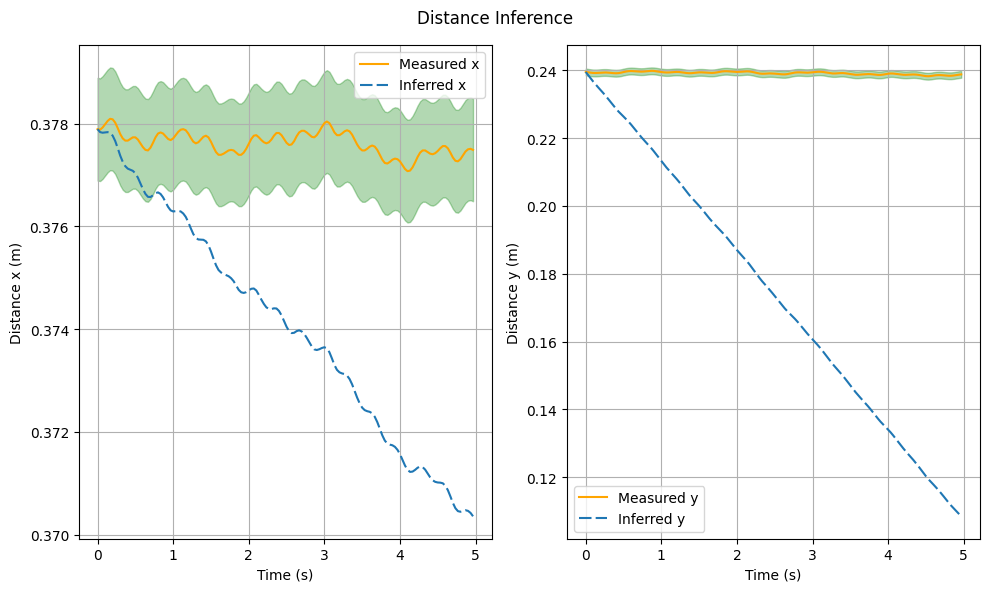

../out/baseline/mlp_model.pth
Model: mlp_model, Mean Error: 0.0648, Max Error: 0.1297, Error Std Dev: 0.0377


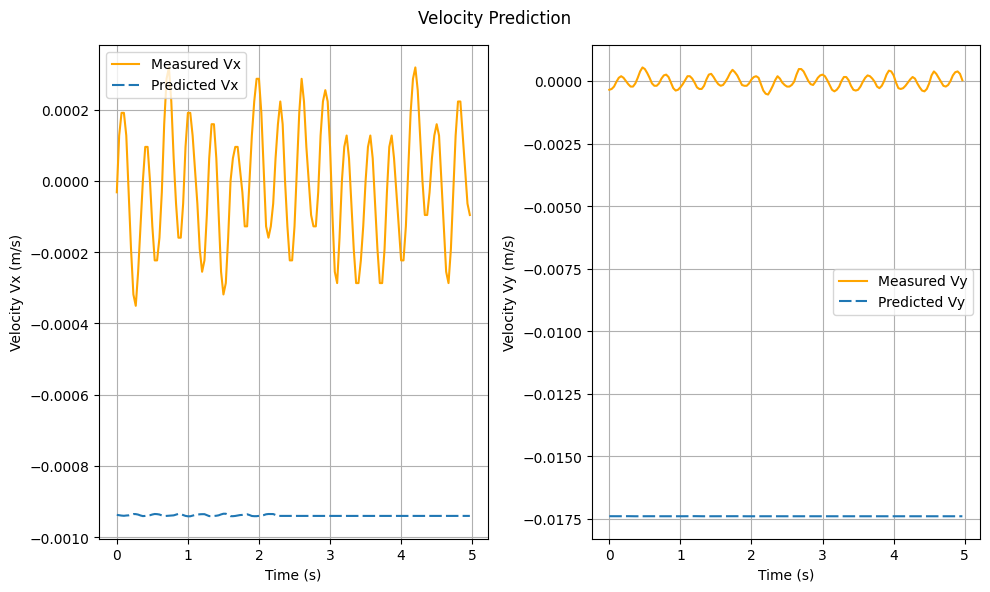

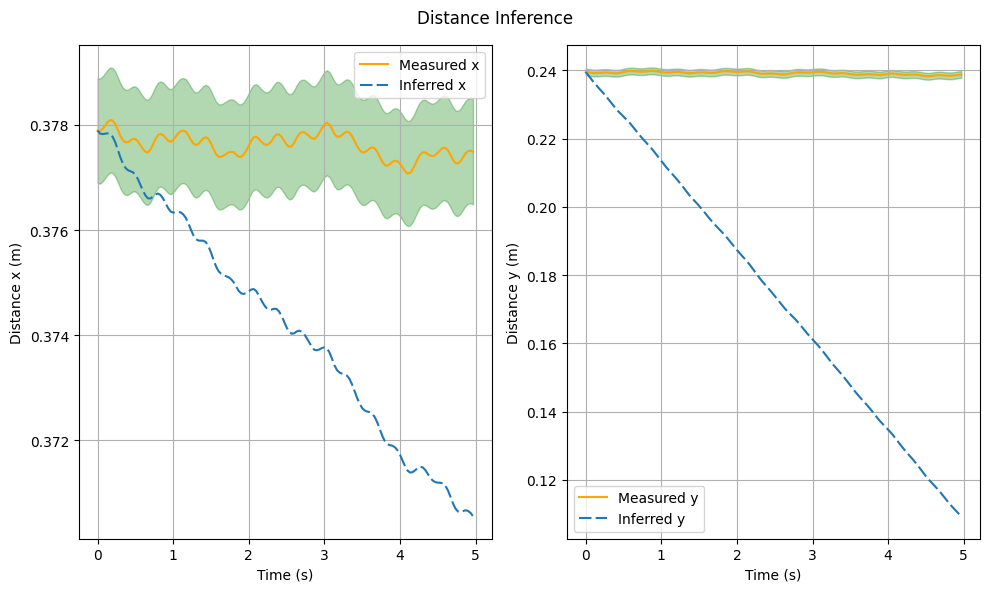

In [28]:
import torch
import numpy as np
import os
import warnings

# Define model parameters
input_dim = 17  # Adjust based on your data
hidden_dim = 34
output_dim = 2
num_layers = 3

# Define models
models = {
    "lstm_model": LSTMModel(input_dim, hidden_dim, output_dim, num_layers),
    "mlp_model": MLP(input_dim, hidden_dim, output_dim)
}

# Iterate over models
for model_name, model in models.items():
    model_path = os.path.join('..', 'out', 'baseline', f'{model_name}.pth')
    print(model_path)
    if not os.path.exists(model_path):
        print(f"Skipping {model_name}, model file not found.")
        continue

    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        pred_y = model(test_x).numpy()
        pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[-1]).astype(np.complex64)

        reference_signal_x = np.copy(test_y)[:, 0]
        target_signal_x = pred_y[:, 0]
        adjusted_vx = adjust_signal_single(target_signal_x, *full_x_params)

        reference_signal_y = np.copy(test_y)[:, 1]
        target_signal_y = pred_y[:, 1]
        adjusted_vy = adjust_signal_single(target_signal_y, *full_y_params)

        best_segmented_vx, best_segmented_vy = adjust_signal([adjusted_vx, adjusted_vy], *segment_params)

        start_pos = test_x.numpy()[ref_segment_start, 0, :2].tolist()
        true_pos = gen_pos_from_vel(
            start_pos,
            reference_signal_x[ref_segment_start:ref_segment_start + segment_length],
            reference_signal_y[ref_segment_start:ref_segment_start + segment_length]
        )

        gen_pos = gen_pos_from_vel(
            start_pos,
            best_segmented_vx[target_segment_start:target_segment_start + segment_length] * weight_adjustment +
            reference_signal_x[ref_segment_start:ref_segment_start + segment_length] * (1 - weight_adjustment),
            best_segmented_vy[target_segment_start:target_segment_start + segment_length] * weight_adjustment +
            reference_signal_y[ref_segment_start:ref_segment_start + segment_length] * (1 - weight_adjustment)
        )

        errors = np.sqrt((true_pos[0] - gen_pos[0]) ** 2 + (true_pos[1] - gen_pos[1]) ** 2)
        mean_error = np.mean(errors)
        max_error = np.max(errors)
        std_error = np.std(errors)

        print(f'Model: {model_name}, Mean Error: {mean_error:.4f}, Max Error: {max_error:.4f}, Error Std Dev: {std_error:.4f}')

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            plot_signals(
                [
                    best_segmented_vx[target_segment_start:target_segment_start + segment_length],
                    best_segmented_vy[target_segment_start:target_segment_start + segment_length]
                ],
                [
                    reference_signal_x[ref_segment_start:ref_segment_start + segment_length],
                    reference_signal_y[ref_segment_start:ref_segment_start + segment_length]
                ],
                gen_pos,
                true_pos,
                model_name,
                show=True
            )
